In [1]:
# import libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset
import copy
import matplotlib.pyplot as plt
from IPython import display

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = T.Compose([ T.ToTensor(),
                        T.RandomHorizontalFlip(p=.5),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dev_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
dev_set = Subset(dev_test,randidx[:5000]) # Subset for devset
test_set = Subset(dev_test,randidx[5000:]) # Subset for test

# transform to dataloaders
batchsize = 32
train_loader = DataLoader(train_set,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader = DataLoader(dev_set, batch_size=len(dev_set))
test_loader = DataLoader(test_set, batch_size=len(test_set))

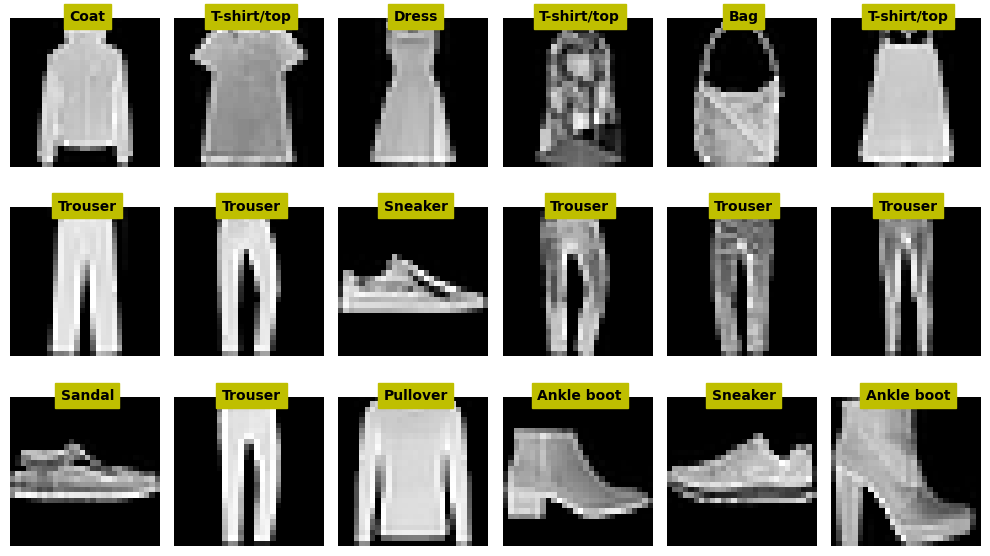

In [4]:
X,y = next(iter(test_loader))
fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i, ax) in enumerate(axs.flatten()):

  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5
  label = train_set.classes[y[i]]

  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
def create_AE_model():
    class AE_Model(nn.Module):
        def __init__(self):
            super().__init__()

            self.conv1 = nn.Conv2d(1,16,3,padding=1,stride=2)
            self.conv2 = nn.Conv2d(16,32,3,padding=1,stride=2)
            self.conv3 = nn.ConvTranspose2d(32,16,4,padding=1,stride=2)
            self.conv4 = nn.ConvTranspose2d(16,1,4,padding=1,stride=2)

        def forward(self,x):
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))
            x = F.relu(self.conv4(x))
            return x
    
    model = AE_Model()
    loss_fun = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    
    return model, loss_fun, optimizer

In [6]:
def train_model():
    EPOCHS = 20

    model, loss_fun, optimizer = create_AE_model()
    model.to(device)
    
    train_loss = torch.zeros(EPOCHS)
    dev_loss = torch.zeros(EPOCHS)

    for i in range(EPOCHS):
        model.train()
        batch_loss = []
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            y_hat = model(X)
            loss = loss_fun(y_hat, X)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
    
        train_loss[i] = np.mean(batch_loss)

        model.eval()
        X, y = next(iter(dev_loader))

        X = X.to(device)
        y = y.to(device)

        with torch.inference_mode():
            y_hat = model(X)
            loss = loss_fun(y_hat, X)

        dev_loss[i] = loss.item()
    return train_loss, dev_loss, model

In [7]:
train_loss, dev_loss, ae_model = train_model()

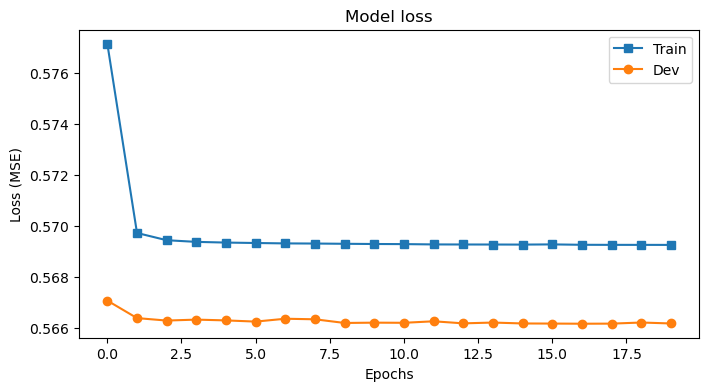

In [8]:
fig = plt.figure(figsize=(8,4))

plt.plot(train_loss,'s-',label='Train')
plt.plot(dev_loss,'o-',label='Dev')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss')
plt.legend()

plt.show()

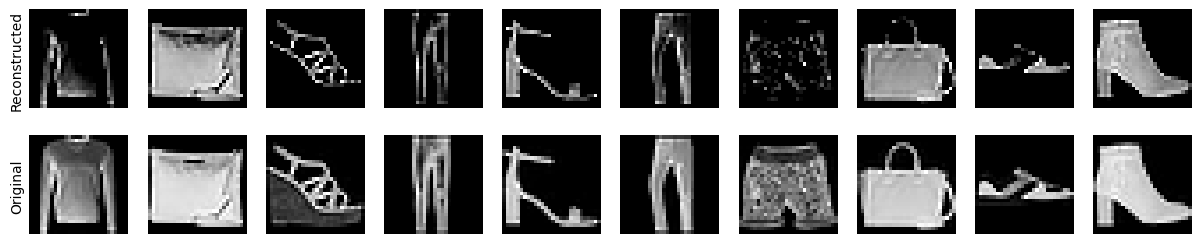

In [9]:
X,y = next(iter(dev_loader))

ae_model.cpu()
ae_model.eval() # switch to test mode
yHat = ae_model(X)

fig,axs = plt.subplots(2,10,figsize=(15,3))

for i in range(10):
  pic = yHat[i,0,:,:].detach()
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].axis('off')

  pic = X[i,0,:,:].detach()
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic,cmap='gray')
  axs[1,i].axis('off')

  if i==0:
    axs[0,0].text(-6,14,'Reconstructed',rotation=90,va='center')
    axs[1,0].text(-6,14,'Original',rotation=90,va='center')
  
plt.show()

In [10]:
def create_class_model():
    class CL_Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1,16,3,padding=1,stride=2)
            self.conv2 = nn.Conv2d(16,32,3,padding=1,stride=2)
            self.fc1 = nn.Linear(7*7*32,50)
            self.fc2 = nn.Linear(50,10)
        
        def forward(self,x):
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            n_units = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(n_units))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return x
    
    model = CL_Model()
    loss_fun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    return model, loss_fun, optimizer

In [11]:
def train_class_model():

    model, loss_fun, optimizer = create_class_model()

    EPOCHS = 10
    model.to(device)

    # initialize losses
    train_loss = torch.zeros(EPOCHS)
    dev_loss   = torch.zeros(EPOCHS)
    train_acc  = torch.zeros(EPOCHS)
    dev_acc    = torch.zeros(EPOCHS)

    for i in range(EPOCHS):
        model.train()
        batch_loss = []
        batch_acc = []

        for X, y in train_loader:

            X = X.to(device)
            y = y.to(device)

            y_hat = model(X)
            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
            batch_acc.append(torch.mean((torch.argmax(y_hat,axis=1)==y).float()).item())

        train_loss[i] = np.mean(batch_loss)
        train_acc[i] = 100 * np.mean(batch_acc)

        model.eval()
        X, y = next(iter(dev_loader))
        X = X.to(device)
        y = y.to(device)

        with torch.inference_mode():
            y_hat = model(X)
            loss = loss_fun(y_hat, y)

        dev_loss[i] = loss.item()
        dev_acc[i] = 100 * torch.mean((torch.argmax(y_hat,axis=1)==y).float()).item()

    return train_loss, dev_loss, train_acc, dev_acc, model        


In [12]:
train_loss_naive, dev_loss_naive, train_acc_naive, dev_acc_naive, class_model = train_class_model()

loss_fun = nn.CrossEntropyLoss()

class_model.eval()
X, y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

with torch.inference_mode():
    y_hat = class_model(X)
    loss = loss_fun(y_hat, y)

test_loss_naive = loss.item()
test_acc_naive = 100 * torch.mean((torch.argmax(y_hat,axis=1)==y).float()).item()

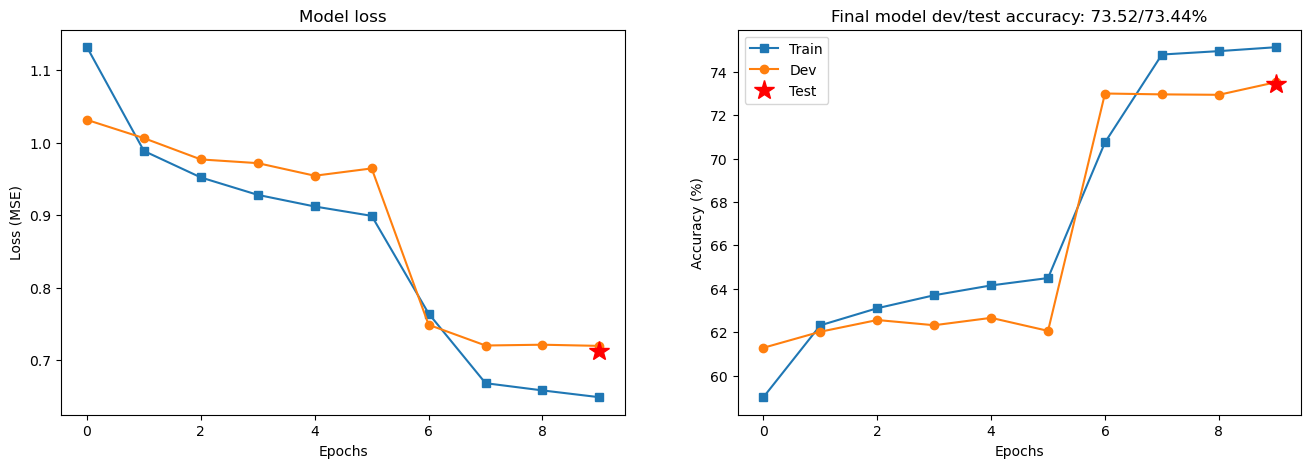

In [13]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_loss_naive,'s-',label='Train')
ax[0].plot(dev_loss_naive,'o-',label='Dev')
ax[0].plot(len(dev_loss_naive)-1,test_loss_naive,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(train_acc_naive,'s-',label='Train')
ax[1].plot(dev_acc_naive,'o-',label='Dev')
ax[1].plot(len(dev_acc_naive)-1,test_acc_naive,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {dev_acc_naive[-1]:.2f}/{test_acc_naive:.2f}%')
ax[1].legend()

plt.show()

In [14]:
pretrain_model,loss_fun,optimizer = create_class_model()

# then replace the conv weights in TARGET model from encoder weights in SOURCE model
for target,source in zip(pretrain_model.named_parameters(),ae_model.named_parameters()):
  print('PRETRAIN: ' + target[0] + '  AENET: ' + source[0])
  if 'enc' in target[0]:
    target[1].data = copy.deepcopy(source[1].data )

PRETRAIN: conv1.weight  AENET: conv1.weight
PRETRAIN: conv1.bias  AENET: conv1.bias
PRETRAIN: conv2.weight  AENET: conv2.weight
PRETRAIN: conv2.bias  AENET: conv2.bias
PRETRAIN: fc1.weight  AENET: conv3.weight
PRETRAIN: fc1.bias  AENET: conv3.bias
PRETRAIN: fc2.weight  AENET: conv4.weight
PRETRAIN: fc2.bias  AENET: conv4.bias


In [ ]:
train_loss_pre,dev_loss_pre,train_acc_pre,dev_acc_pre,pretrain_model = train_class_model()

pretrain_model.eval()
X, y = next(iter(test_loader))

X = X.to(device)
y = y.to(device)

with torch.inference_mode():
    y_hat = pretrain_model(X)
    loss = loss_fun(y_hat, y)

test_loss_pre = loss.item()
test_acc_pre = 100 * torch.mean((torch.argmax(y_hat, axis=1)==y).float()).item()

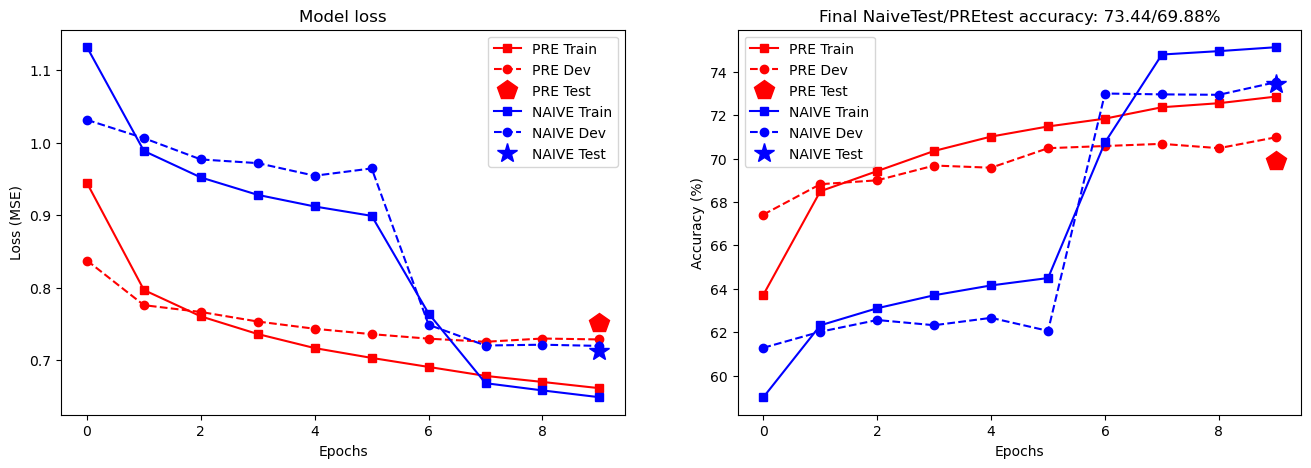

In [17]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_loss_pre,'rs-',label='PRE Train')
ax[0].plot(dev_loss_pre,'ro--',label='PRE Dev')
ax[0].plot(len(dev_loss_pre)-1,test_loss_pre,'rp',markersize=15,label='PRE Test')
ax[0].plot(train_loss_naive,'bs-',label='NAIVE Train')
ax[0].plot(dev_loss_naive,'bo--',label='NAIVE Dev')
ax[0].plot(len(dev_loss_naive)-1,test_loss_naive,'b*',markersize=15,label='NAIVE Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(train_acc_pre,'rs-',label='PRE Train')
ax[1].plot(dev_acc_pre,'ro--',label='PRE Dev')
ax[1].plot(len(dev_acc_pre)-1,test_acc_pre,'rp',markersize=15,label='PRE Test')
ax[1].plot(train_acc_naive,'bs-',label='NAIVE Train')
ax[1].plot(dev_acc_naive,'bo--',label='NAIVE Dev')
ax[1].plot(len(dev_acc_naive)-1,test_acc_naive,'b*',markersize=15,label='NAIVE Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final NaiveTest/PREtest accuracy: {test_acc_naive:.2f}/{test_acc_pre:.2f}%')
ax[1].legend()

plt.show()

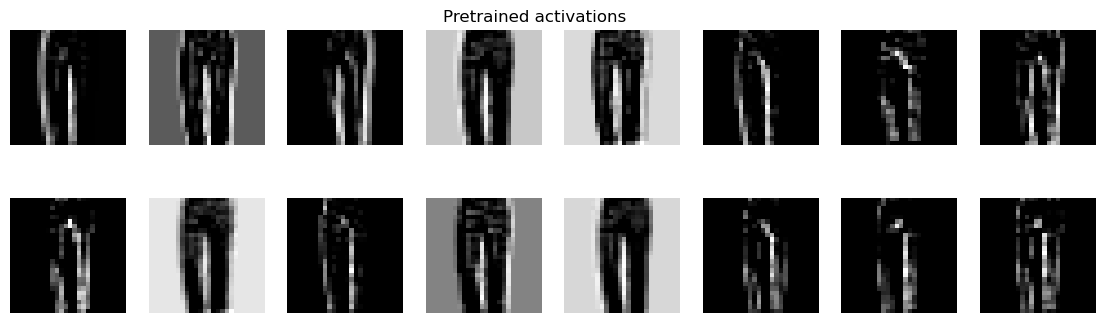

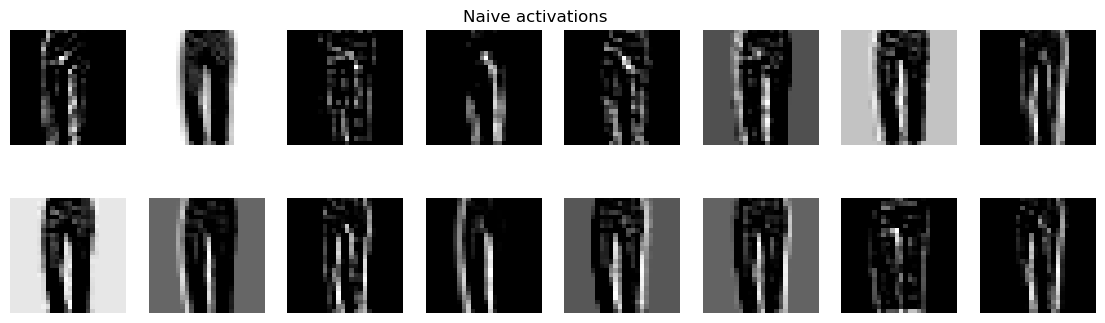

In [18]:
x = X[10,:,:,:].view(1,1,28,28)

layer1ActPre = F.relu(F.conv2d(x,pretrain_model.conv1.weight))
layer1ActNai = F.relu(F.conv2d(x,class_model.conv1.weight))

fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
  act = torch.squeeze(layer1ActPre[0,i,:,:]).detach().cpu()
  ax.imshow(act,cmap='gray')
  ax.axis('off')

plt.suptitle('Pretrained activations',y=.9)
plt.show()

fig,axs = plt.subplots(2,8,figsize=(14,4))
for i,ax in enumerate(axs.flatten()):
  act = torch.squeeze(layer1ActNai[0,i,:,:]).detach().cpu()
  ax.imshow(act,cmap='gray')
  ax.axis('off')

plt.suptitle('Naive activations',y=.9)
plt.show()